In [27]:
import os
from datetime import datetime
import sys
import cdsapi
import copernicusmarine as cm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from neural_lam import constants
from download_data import load_mask, select

### Obtenemos las coordenadas de nuestra área de estudio 

Bathymetry mask file found. Loading from file.


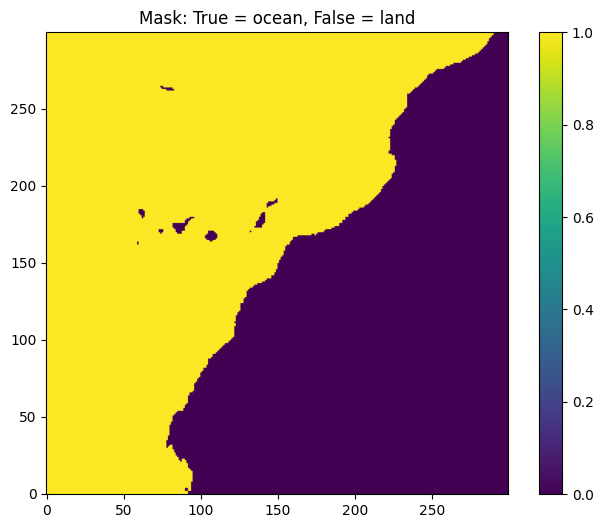

In [28]:
mask_path = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/data/atlantic/static/bathy_mask.nc"
data = np.load("D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/data/atlantic/raw/reanalysis/20180101.npy")
mask = load_mask(mask_path)
latitude = mask.latitude.values 
longitude = mask.longitude.values
plt.figure(figsize=(8, 6))
plt.imshow(mask.values, origin='lower', cmap='viridis')
plt.title("Mask: True = ocean, False = land")
plt.colorbar()
plt.show()

### Probamos a generar pesos de la malla con el enfoque usado en el SeaCast original

In [29]:
def generate_grid_weights_from_latitude(lat, lon, mask):
    """
    Generates grid weights as a 2D array with shape (len(lat), len(lon)).
    The weights are based on the cell size along the x-axis (east-west), which depends on the latitude.
    """
    delta_lat = lat[1] - lat[0]
    delta_lon = lon[1] - lon[0]

    delta_lat_rad = np.deg2rad(delta_lat)
    delta_lon_rad = np.deg2rad(delta_lon)

    # Radius of the Earth in meters
    R = 6371000

    e1t = R * np.cos(np.deg2rad(lat)) * delta_lon_rad

    # Normalize e1t with respect to its mean
    grid_weights_1d = e1t / np.mean(e1t)

    if np.ma.is_masked(grid_weights_1d):
        grid_weights_1d = grid_weights_1d.filled(0.0)
    grid_weights_1d = np.nan_to_num(np.array(grid_weights_1d), nan=0.0)

    # Extend to 2 dimensions using the longitude
    grid_weights_2d = np.tile(grid_weights_1d[:, np.newaxis], (1, len(lon)))
    
    # Handle the possibility of depth being an extra dimension in the mask to apply it
    if len(mask.values.shape) == 3:
        mask = mask.isel(depth=0)

    # Apply the mask to the weights to keep only the ocean values
    grid_weights_2d = grid_weights_2d * mask.values
    return grid_weights_2d

def save_grid_weights(grid_weights, path):
    """
    Saves grid weights to a npy file
    """
    np.save(path, grid_weights)


### Probamos a generar los pesos mediante la fórmula usada en el WeatherBench original

In [30]:
def generate_grid_weights_from_latitude_cosine(mask: xr.DataArray) -> np.ndarray:
    """
    From a 0-1 mask indicating the presence of ocean in each cell, generates weights for each cell based on latitude.
    Weights are calculated as the cosine of the latitude, normalized with respect to the mean of the weights.

    Args:
    mask: xr.DataArray containing the ocean mask. It must be 2D. It is handled within the function in case it's 3D.

    Returns:
    np.ndarray with normalized weights in ocean positions of the mask.
    """
    # Reshape the mask to ensure it is 2D and has no depth
    if len(mask.values.shape) == 3:
        mask = mask.isel(depth=0)
        
    # Create a grid of zeros with the same shape as the mask to place weights in ocean positions later
    grid_out = np.zeros(mask.values.shape)
    
    # Convert latitude coordinate to a 2D matrix matching the mask shape to select latitudes corresponding to the ocean
    lat_2d = np.broadcast_to(mask.latitude.values[:, None], mask.values.shape)

    # Extract latitudes in positions where the mask is 1, corresponding to the ocean in our case
    latitude_ocean = lat_2d[mask.values == 1]

    # Apply the formula
    grid_weights = np.cos(np.deg2rad(latitude_ocean))
    mean = np.mean(grid_weights, axis=0)
    grid_weights_normalized = grid_weights / mean

    # Place normalized grid weights in mask positions where the value is 1
    grid_out[mask.values == 1] = grid_weights_normalized
    return grid_out


In [31]:
path_to_save = "grid_weights_testing.npy"
grid_weights = generate_grid_weights_from_latitude(latitude, longitude, mask)
save_grid_weights(grid_weights, path_to_save)
grid_weigths_cosine = generate_grid_weights_from_latitude_cosine(mask)
print(grid_weights.shape)
path_to_save_cosine = "grid_weights_cosine.npy"
save_grid_weights(grid_weigths_cosine, path_to_save_cosine)

(300, 300)


### Visualizamos resultados obtenidos con ambos enfoques

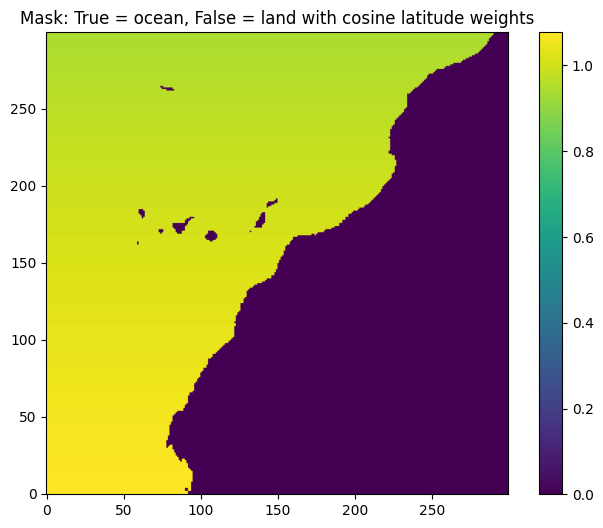

In [32]:
grid_weights = np.load(path_to_save_cosine)

plt.figure(figsize=(8, 6))
plt.imshow(grid_weights, origin='lower', cmap='viridis')
plt.title("Mask: True = ocean, False = land with cosine latitude weights")
plt.colorbar()
plt.show()

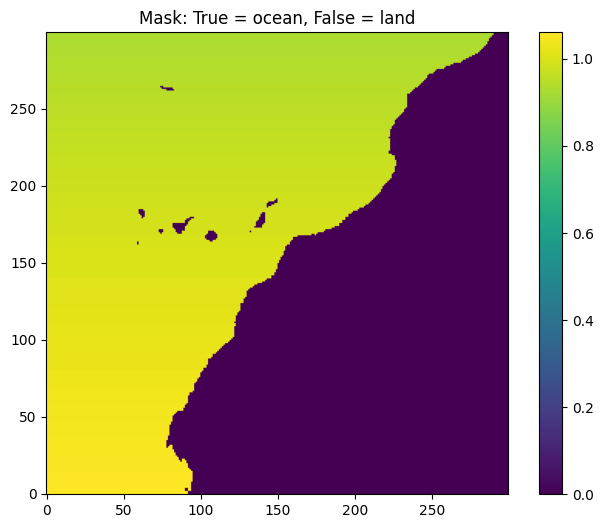

In [33]:
grid_weights = np.load(path_to_save)

plt.figure(figsize=(8, 6))
plt.imshow(grid_weights, origin='lower', cmap='viridis')
plt.title("Mask: True = ocean, False = land")
plt.colorbar()
plt.show()

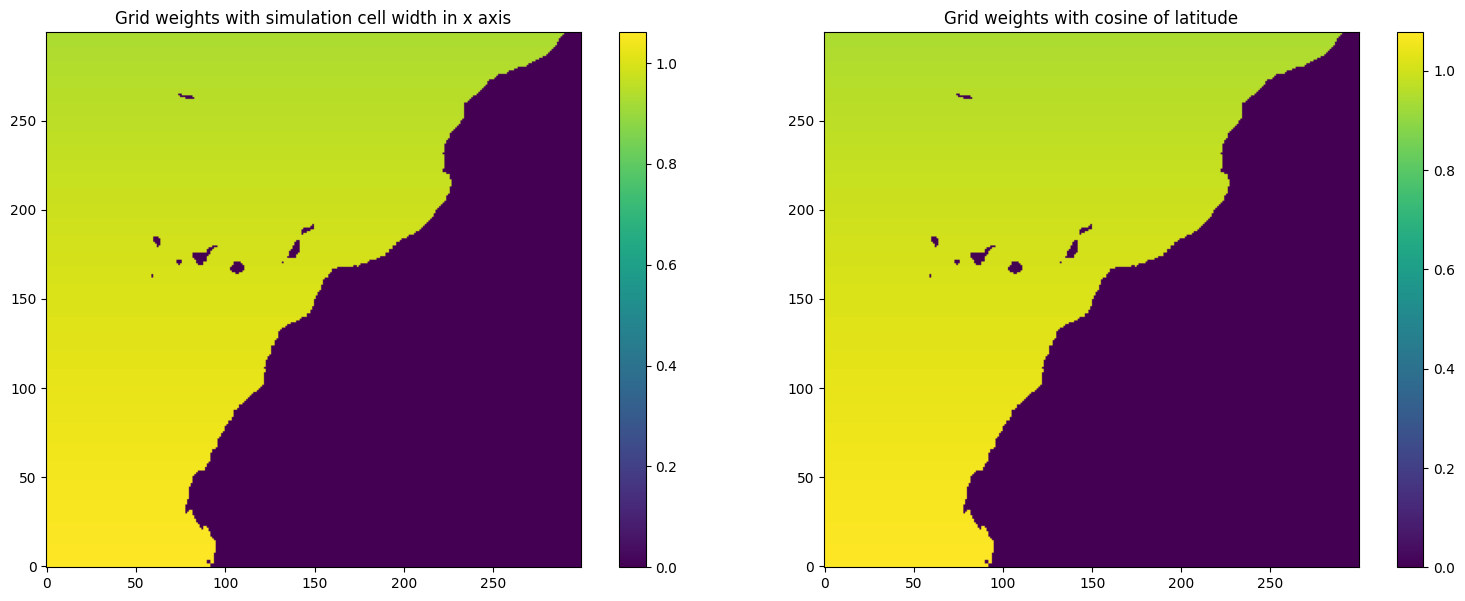

In [34]:
grid_weights = np.load(path_to_save)
grid_weights_cosine = np.load(path_to_save_cosine)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

im1 = axs[0].imshow(grid_weights, origin='lower', cmap='viridis')
axs[0].set_title("Grid weights with simulation cell width in x axis")
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(grid_weights_cosine, origin='lower', cmap='viridis')
axs[1].set_title("Grid weights with cosine of latitude")
fig.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.show()

### Descargamos la máscara usada en el SeaCast original y la usamos para generar los pesos de la malla con el fin de comparar los resultados obtenidos y comprobar que los cálculos son correctos.

In [35]:
coord_data = cm.open_dataset(
        dataset_id="cmems_mod_med_phy_my_4.2km_static",
        dataset_part="coords",
        dataset_version="202211",
        service="static-arco",
        variables=["e1t"],
    )
mediterranean_mask_path = "D:/ULPGC/4Curso/TFG/seacast_code/seacast/data/mediterranean/static/bathy_mask.nc"
mediterranean_mask = load_mask(mediterranean_mask_path)
coord_data = select(coord_data, mediterranean_mask)
grid_weights = coord_data.e1t / coord_data.e1t.mean()
np.save(
    f"grid_weights_mediterranean.npy", np.nan_to_num(grid_weights, nan=0.0)
)

INFO - 2025-02-25T10:11:38Z - Selected dataset version: "202211"
INFO - 2025-02-25T10:11:38Z - Selected dataset part: "coords"


Bathymetry mask file found. Loading from file.


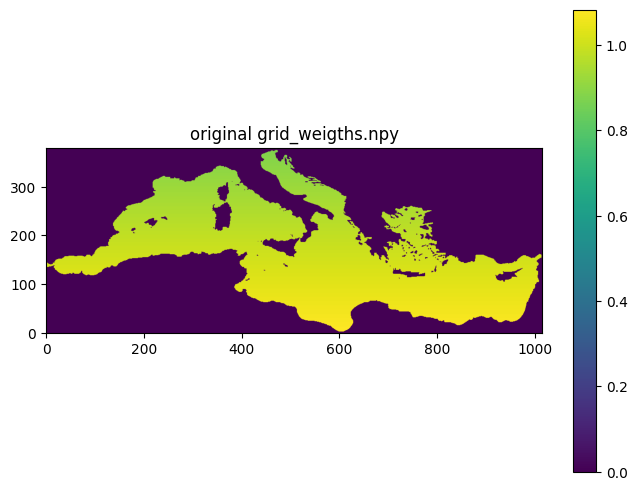

In [36]:
data = np.load("grid_weights_mediterranean.npy")

plt.figure(figsize=(8, 6))
plt.imshow(data, origin="lower",cmap='viridis')
plt.title('original grid_weigths.npy')
plt.colorbar()
plt.show()

In [37]:
latitude = mediterranean_mask.latitude.values
longitude = mediterranean_mask.longitude.values

path_to_save = "grid_weights_testing_mediterranean.npy"
grid_weights = generate_grid_weights_from_latitude(latitude, longitude, mediterranean_mask)
grid_weights_cosine = generate_grid_weights_from_latitude_cosine(mediterranean_mask)
print(grid_weights.shape)
save_grid_weights(grid_weights, path_to_save)
path_to_save_cosine = "grid_weights_cosine_mediterranean.npy"
save_grid_weights(grid_weights_cosine, path_to_save_cosine)

(380, 1016)


(380, 1016)


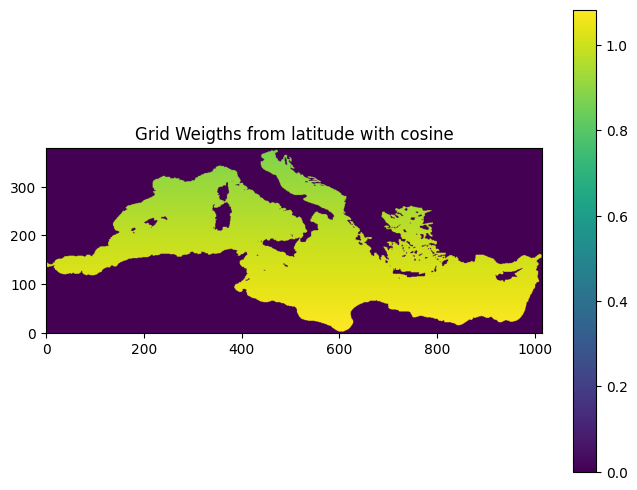

In [38]:
grid_weights_cosine = np.load(path_to_save_cosine)
print(grid_weights_cosine.shape)
plt.figure(figsize=(8, 6))
plt.imshow(grid_weights_cosine, origin='lower', cmap='viridis')
plt.title("Grid Weigths from latitude with cosine")
plt.colorbar()
plt.show()

(380, 1016)


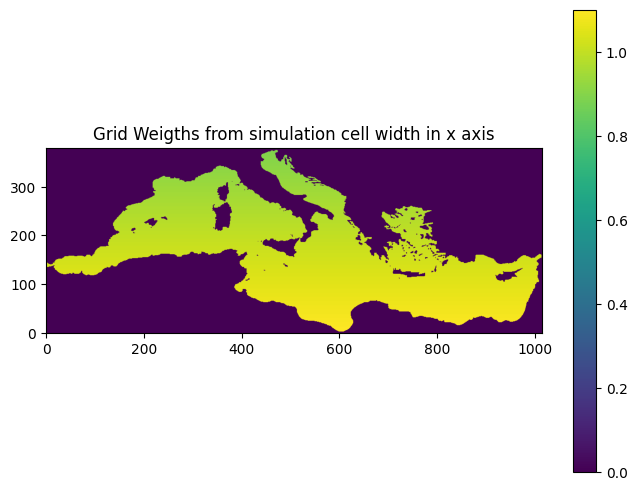

In [39]:
grid_weights = np.load(path_to_save)
print(grid_weights.shape)
plt.figure(figsize=(8, 6))
plt.imshow(grid_weights, origin='lower', cmap='viridis')
plt.title("Grid Weigths from simulation cell width in x axis")
plt.colorbar()
plt.show()

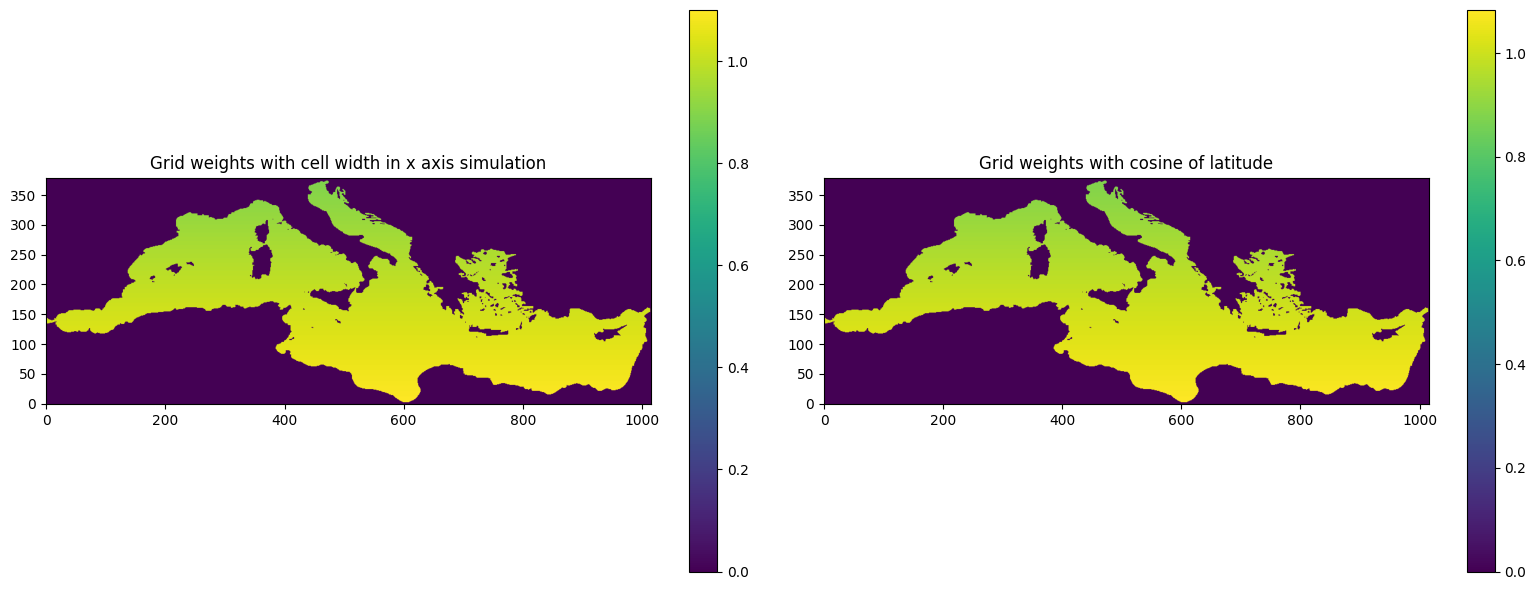

In [40]:
grid_weights = np.load(path_to_save)
grid_weights_cosine = np.load(path_to_save_cosine)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

im1 = axs[0].imshow(grid_weights, origin='lower', cmap='viridis')
axs[0].set_title("Grid weights with cell width in x axis simulation")
fig.colorbar(im1, ax=axs[0])

# Segundo gráfico: grid_weights_cosine
im2 = axs[1].imshow(grid_weights_cosine, origin='lower', cmap='viridis')
axs[1].set_title("Grid weights with cosine of latitude")
fig.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.show()

### Comparamos si los pesos de la máscara del SeaCast original son iguales a los pesos obtenidos con el enfoque de generar los valores del tamaño de celda en el eje x. En caso negativo, visualizamos las diferencias.

In [41]:
if np.array_equal(data, grid_weights):
    print("files are equal")
else:
    print("files are not equal")
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            if data[i][j] != grid_weights[i][j]:
                print(f"Position ({i}, {j}): {data[i][j]} - {grid_weights[i][j]} = {data[i][j] - grid_weights[i][j]}")
                break


files are not equal
Position (3, 598): 1.0829660892486572 - 1.1002700328826904 = -0.017303943634033203
Position (4, 596): 1.082505464553833 - 1.0998018980026245 = -0.017296433448791504
Position (5, 594): 1.0820441246032715 - 1.0993331670761108 = -0.017289042472839355
Position (6, 592): 1.0815821886062622 - 1.098863959312439 = -0.017281770706176758
Position (7, 591): 1.0811197757720947 - 1.0983941555023193 = -0.01727437973022461
Position (8, 589): 1.0806567668914795 - 1.0979236364364624 = -0.01726686954498291
Position (9, 588): 1.0801931619644165 - 1.0974526405334473 = -0.01725947856903076
Position (10, 586): 1.0797290802001953 - 1.096981167793274 = -0.017252087593078613
Position (11, 585): 1.0792642831802368 - 1.0965089797973633 = -0.017244696617126465
Position (12, 584): 1.0787990093231201 - 1.0960361957550049 = -0.017237186431884766
Position (13, 583): 1.0783331394195557 - 1.0955629348754883 = -0.017229795455932617
Position (14, 582): 1.0778666734695435 - 1.0950889587402344 = -0.0172

### Podemos considerar que los pesos obtenidos son significativamente cercanos a los pesos originales dada la diferencia obtenida.

### Comprobamos las diferencias que puedan haber en los resultados obtenidos en el cálculo de los pesos de la malla con ambos enfoques.

In [42]:
if np.array_equal(grid_weights_cosine, grid_weights):
    print("files are equal")
else:
    print("files are not equal")
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            if data[i][j] != grid_weights[i][j]:
                print(f"Position ({i}, {j}): {grid_weights[i][j]} - {grid_weights_cosine[i][j]} = {grid_weights[i][j] - grid_weights_cosine[i][j]}")
                break

files are not equal
Position (3, 598): 1.1002700328826904 - 1.0829660892486572 = 0.017303943634033203
Position (4, 596): 1.0998018980026245 - 1.0825053453445435 = 0.017296552658081055
Position (5, 594): 1.0993331670761108 - 1.082044005393982 = 0.017289161682128906
Position (6, 592): 1.098863959312439 - 1.0815821886062622 = 0.017281770706176758
Position (7, 591): 1.0983941555023193 - 1.0811197757720947 = 0.01727437973022461
Position (8, 589): 1.0979236364364624 - 1.08065664768219 = 0.01726698875427246
Position (9, 588): 1.0974526405334473 - 1.0801931619644165 = 0.01725947856903076
Position (10, 586): 1.096981167793274 - 1.0797289609909058 = 0.017252206802368164
Position (11, 585): 1.0965089797973633 - 1.0792642831802368 = 0.017244696617126465
Position (12, 584): 1.0960361957550049 - 1.0787988901138306 = 0.017237305641174316
Position (13, 583): 1.0955629348754883 - 1.0783331394195557 = 0.017229795455932617
Position (14, 582): 1.0950889587402344 - 1.0778666734695435 = 0.017222285270690918

In [43]:
print(np.abs(np.sum(grid_weights - grid_weights_cosine)))

2316.682185947895


### Podemos comprobar que las diferencias son mínimas y que los resultados obtenidos son significativamente cercanos.

### Comprobamos que todas las normalizaciones se hacen correctamente sumando todos los pesos y dividiendolo entre el número de nodos de la malla. Tomaremos el caso de estudio del área del Mediterraneo para esta prueba

In [44]:
n_nodes = 144990

print(data.shape)

count = np.sum(data)
print("count: ", count)
data2 = count / n_nodes
print(data2)
print(np.sum(data2))

(380, 1016)
count:  144989.97
0.99999976
0.99999976


### Ver que la normalizacion con el cálculo del ancho de celda en el eje x esta bien hecha

In [45]:
print(grid_weights.shape)

count = np.sum(grid_weights)
print("count: ", count)
grid_weights2 = count / n_nodes
print(grid_weights2)
print(np.sum(grid_weights2))

(380, 1016)
count:  147306.66
1.0159781
1.0159781


### Ver que la normalizacion con el coseno esta bien hecha

In [46]:
print(grid_weights_cosine.shape)

count = np.sum(grid_weights_cosine)
print("count: ", count)
grid_weights_cosine2 = count / n_nodes
print(grid_weights_cosine2)
print(np.sum(grid_weights_cosine2))

(380, 1016)
count:  144989.99684721231
0.999999978255137
0.999999978255137


### Nos quedamos con el cálculo de los pesos mediante el coseno

In [47]:
path1 = "grid_weights_testing.npy"
path2 = "grid_weights_cosine.npy"
path3 = "grid_weights_testing_mediterranean.npy"
path4 = "grid_weights_cosine_mediterranean.npy"
path5 = "grid_weights_mediterranean.npy"
os.remove(path1)
os.remove(path2)
os.remove(path3)
os.remove(path4)
os.remove(path5)

### Visualizamos la máscara llamada boundary mask del SeaCast original

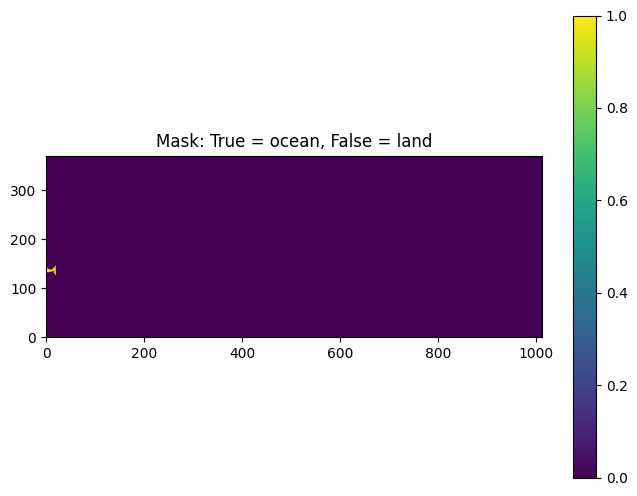

In [48]:
sea_depth_path = "D:/ULPGC/4Curso/TFG/seacast_code/seacast/data/mediterranean/static/boundary_mask.npy"
sea_depth = np.load(sea_depth_path)

sea_depth = sea_depth[0]
plt.figure(figsize=(8, 6))
plt.imshow(sea_depth, origin='lower', cmap='viridis')
plt.title("Mask: True = ocean, False = land")
plt.colorbar()

plt.show()

### Visualizamos la máscara llamada sea topography del SeaCast original

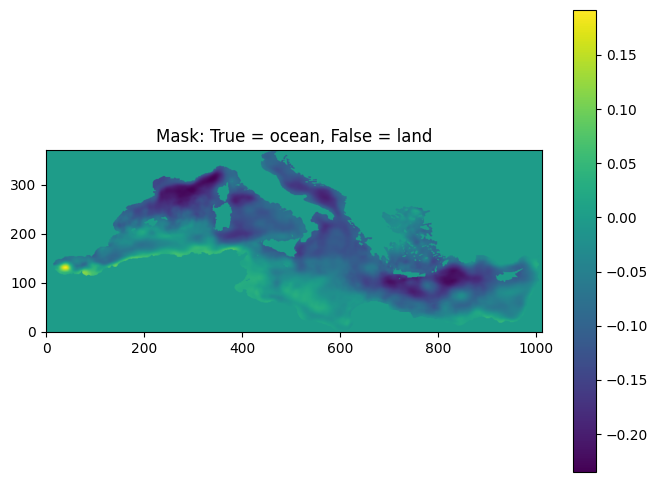

In [49]:
sea_depth_path = "D:/ULPGC/4Curso/TFG/seacast_code/seacast/data/mediterranean/static/sea_topography.npy"
sea_depth = np.load(sea_depth_path)

plt.figure(figsize=(8, 6))
plt.imshow(sea_depth, origin='lower', cmap='viridis')
plt.title("Mask: True = ocean, False = land")
plt.colorbar()

plt.show()

### Visualizamos la máscara llamada sea depth del SeaCast original

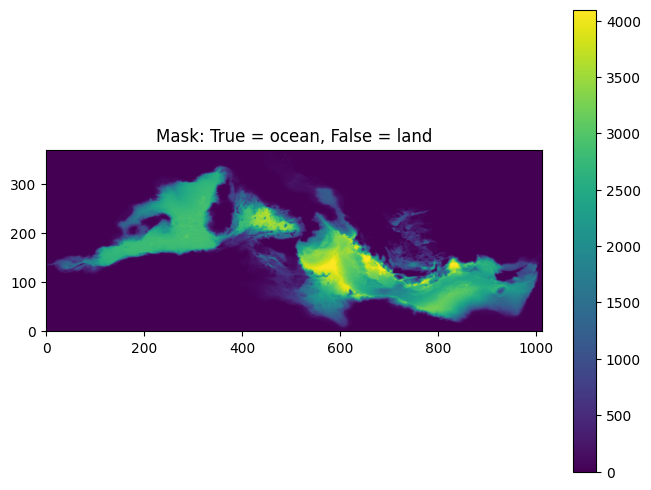

In [50]:
sea_depth_path = "D:/ULPGC/4Curso/TFG/seacast_code/seacast/data/mediterranean/static/sea_depth.npy"
sea_depth = np.load(sea_depth_path)

plt.figure(figsize=(8, 6))
plt.imshow(sea_depth, origin='lower', cmap='viridis')
plt.title("Mask: True = ocean, False = land")
plt.colorbar()

plt.show()

### Verificamos que los cambios realizados en el archivo **'download_data.py'**

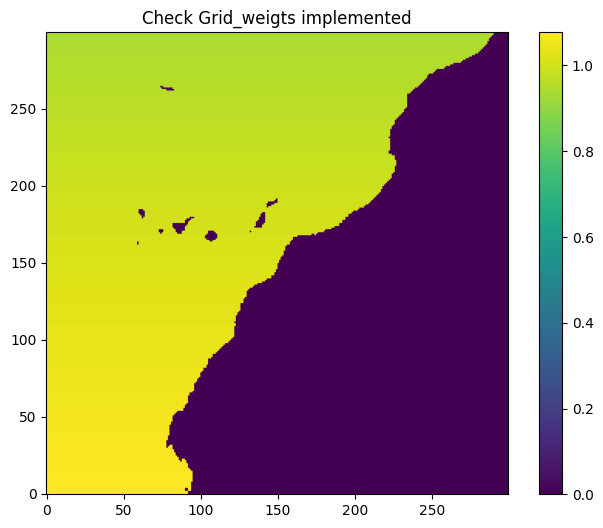

In [51]:
final_grid_weigths_path = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/data/atlantic/static/grid_weights.npy"
final_grid_weigths = np.load(final_grid_weigths_path)

plt.figure(figsize=(8, 6))
plt.imshow(final_grid_weigths, origin='lower', cmap='viridis')
plt.title("Check Grid_weigts implemented")
plt.colorbar()

plt.show()


### Comprobamos que la normalización se ha hecho correctamente

In [52]:
print(final_grid_weigths.shape)
n_nodes = 49061
count = np.sum(final_grid_weigths)
print("count: ", count)
final_grid_weigths2 = count / n_nodes
print(final_grid_weigths2)
print(np.sum(final_grid_weigths2))


(300, 300)
count:  49061.0
1.0
1.0
